In [30]:
%pylab inline
from collections import Counter, defaultdict
import pandas as pd
import glob
import os
import itertools
from matplotlib.legend import Legend
from matplotlib.lines import Line2D
from gcca import GCCA

import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from ee546_utils import *
#MARKERS = list(Line2D.filled_markers)
MARKERS = ['o',  'x', '^', '*','>', '<', 's',  'H',  '8', 'p', 'h',  'D', 'd', 'P']
TISSUES_SHORT_FORM_MAP = {'lv': 'liver',
                          'skm': 'muscle',
                          'br': 'brain',
                          'ht': 'heart',
                          'kd': 'kidney',
                          'cb': 'cerebellum',
                          'lv': 'liver',
                          'ts': 'testes'
                         }

SPECIES_COMMON_NAME_MAP = {"bos_taurus": "Cow",
                           "rattus_norvegicus": "Rat",
                           "pongo_abelii": "Orangutan",
                           "monodelphis_domestica": "Opossum",
                           "macaca_mulatta": "Rhesus",
                           "pan_troglodytes": "Chimp",
                           "mus_musculus": "Mouse",
                           "homo_sapiens": "Human",
                           "gallus_gallus": "Chicken",
                           "ornithorhynchus_anatinus":  "Platypus",
                           "gorilla_gorilla": "Gorilla",
                           "pan_paniscus": "Bonobo"}

SPECIES_COMMON_NAME_MAP_SHORT = {"btaurus": "Cow",
                                 "rnorvegicus": "Rat",
                                 "pabelii": "Orangutan",
                                 "mdomestica": "Opposum",
                                 "mmulatta": "Rhesus",
                                 "ptroglodytes": "Chimp",
                                 "mmusculus": "Mouse",
                                 "hsapiens": "Human",
                                 "ggallus": "Chicken",
                                 "oanatinus":  "Platypus",
                                 "ggorilla": "Gorrila",
                                 "ppaniscus": "Bonobo"}
def species_short(name):
    return name[0] + name.split('_')[1]


def _get_PCA_colors_markers(target_names):
    colors = {}
    indexes = defaultdict(list)
    all_species = {}
    row_colors = []
    for index, target_name in enumerate(target_names):
        target_name = target_name.split('.')[0]
        species = target_name.split('_')[0]
        tissue = target_name.split('_')[1]
        if tissue not in colors.keys():
            colors[tissue] = sns.color_palette('tab10')[len(colors)]
        row_colors.append(colors[tissue])
        indexes[tissue].append(index)
        all_species[index] = species
        
    colors_dict = {}
    colors_list = []
    indexes_x = defaultdict(list)
    indexes_y = defaultdict(list)
    markers_dict = {}
    markers_list = []
    for index, target_name in enumerate(target_names):
        target_name = target_name.split('.')[0]
        species = target_name.split('_')[0]
        tissue = target_name.split('_')[1]
        if tissue not in colors_dict.keys():
            colors_dict[tissue] = sns.color_palette('tab10')[len(colors_dict)]
        if species not in markers_dict.keys():
            markers_dict[species] = MARKERS[len(markers_dict)]
        markers_list.append(markers_dict[species])
        colors_list.append(colors_dict[tissue])
        indexes[tissue].append(index)
    return indexes, markers_list, colors_list, colors_dict, markers_dict

def do_PCA(X, target_names, ax=None):
    sns.set_context('poster')#, font_scale=1.75)
    sns.set_style('white')
    pca = PCA(n_components=min(X.shape))
    X_r = pca.fit(X).transform(X)
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))
    else:
        fig = ax.get_figure()
    colors = sns.color_palette('Paired')
    lw = 2
    indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)


    for tissue, values in indexes.items():
        for value in values:
            ax.scatter(X_r[value, 0], 
                       X_r[value, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_list[value],
                       lw=5)
        
    scatter_points = []
    annotations = []
    for tissue, color in colors_dict.items():
        p = ax.scatter([], [], color=color, label=tissue)
        if tissue in TISSUES_SHORT_FORM_MAP.keys():
            tissue = TISSUES_SHORT_FORM_MAP[tissue]
        annotations.append(tissue)
        scatter_points.append(p)
        
   
    leg = Legend(ax, scatter_points, annotations, title='Tissue',
                 bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
                 fancybox=True, shadow=True,borderaxespad=0,
                 ncol=5, mode="expand")
    ax.add_artist(leg)

    scatter_points = []
    annotations = []
    for species, marker in markers_dict.items():
        p = ax.scatter([], [], marker=marker, color='black', label=species)
        annotations.append(SPECIES_COMMON_NAME_MAP_SHORT[species])
        scatter_points.append(p)
        
    #leg = Legend(ax, scatter_points, annotations, title='Species',
    #             bbox_to_anchor=(1.04, 0), loc="lower left",)# frameon=False)
    leg = Legend(ax, scatter_points, annotations, title='Species',
                 bbox_to_anchor=(1, 1), loc='upper right',borderaxespad=0,
                 #bbox_to_anchor=(0.5, -0.05), loc=0, ncol=5,
                 )# frameon=False)
    ax.add_artist(leg)
    
    #ax.set_title('PCA')
    ax.set_xlabel('PC1 ({:.2f} %)'.format(pca.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC2 ({:.2f} %)'.format(pca.explained_variance_ratio_[1]*100))
    #fig.tight_layout()
    
    return X_r, fig

def _get_CCA_colors_markers(target_names):
    colors_dict = {}
    colors_list = []
    indexes_x = defaultdict(list)
    indexes_y = defaultdict(list)
    markers_dict = {}
    markers_list = []
    for index, target_name in enumerate(target_names):
        target_name = target_name.split('.')[0]
        species = target_name.split('_')[0]
        tissue = target_name.split('_')[1]
        if tissue not in colors_dict.keys():
            colors_dict[tissue] = sns.color_palette('tab10')[len(colors_dict)]
        if species not in markers_dict.keys():
            markers_dict[species] = MARKERS[len(markers_dict)]
        markers_list.append(markers_dict[species])
        colors_list.append(colors_dict[tissue])
        if index < X.shape[0]:
            indexes_x[tissue].append(index)
        else:
            indexes_y[tissue].append(index-X.shape[0])
    return indexes_x, indexes_y, markers_list, colors_list, colors_dict, markers_dict
    
def do_CCA(X, Y, target_names, ax=None):
    
    sns.set_context('poster')#, font_scale=1.7)
    sns.set_style('white')
    cca = CCA(n_components=2)
    cca.fit(X, Y)
    X_c, Y_c = cca.transform(X, Y)
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8.5))
    else:
        fig = ax.get_figure()    #assert 
    indexes_x, indexes_y, markers_list, colors_list, colors_dict, markers_dict = _get_CCA_colors_markers(target_names)
    for tissue, values in indexes_x.items():
        for value in values:
            ax.scatter(X_c[value, 0], 
                       X_c[value, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_list[value],
                       lw=5)
    for tissue, values in indexes_y.items():
        for value in values:
            ax.scatter(Y_c[value, 0], 
                       Y_c[value, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_list[value+X_c.shape[0]],
                       lw=5)
    scatter_points = []
    annotations = []
    for tissue, color in colors_dict.items():
        p = ax.scatter([], [], color=color, label=tissue)
        if tissue in TISSUES_SHORT_FORM_MAP.keys():
            tissue = TISSUES_SHORT_FORM_MAP[tissue]
        annotations.append(tissue)
        scatter_points.append(p)
        
    #leg = Legend(ax, scatter_points, annotations, title='Tissue',
    #             bbox_to_anchor=(1.04,1), loc="upper left",)
    
    leg = Legend(ax, scatter_points, annotations, title='Tissue',
                 bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
                 fancybox=True, shadow=True,borderaxespad=0,
                 ncol=5, mode="expand")
    ax.add_artist(leg)

    scatter_points = []
    annotations = []
    for species, marker in markers_dict.items():
        p = ax.scatter([], [], marker=marker, color='black', label=species)
        annotations.append(SPECIES_COMMON_NAME_MAP_SHORT[species])
        scatter_points.append(p)
        
    #leg = Legend(ax, scatter_points, annotations, title='Species',
    #             bbox_to_anchor=(1.04, 0), loc="lower left",)# frameon=False)
    leg = Legend(ax, scatter_points, annotations, title='Species',
                 bbox_to_anchor=(1, 1), loc='upper right',borderaxespad=0)
    ax.add_artist(leg)
    #ax.set_title('CCA')
    ax.set_xlabel('CC1')
    ax.set_ylabel('CC2')
    #fig.tight_layout()
    #fig.tight_layout()
    return fig

def normalize_df_rowwise(df):
    df_centered = df.sub(df.mean(axis=1), axis=0)
    df_centered = df_centered.div(df_centered.std(axis=1), axis=0)
    return df_centered

Populating the interactive namespace from numpy and matplotlib


## 01. Read Data

In [2]:
ortho_pairwise = {}
for f in glob.glob('../ortholog_tsv/*.tsv'):
    if 'ortholog_one2one' in f:
        continue
    second_species = f.split('/')[-1].replace('.tsv', '').split('_')[-1]
    print(f)
    ortho_pairwise[f.split('/')[-1].replace('.tsv', '')] = pd.read_table(f)[['ensembl_gene_id', '{}_homolog_ensembl_gene'.format(second_species), '{}_homolog_orthology_type'.format(second_species)]].set_index('ensembl_gene_id')

../ortholog_tsv/mmusculus_btaurus.tsv
../ortholog_tsv/mmusculus_ggallus.tsv
../ortholog_tsv/mmusculus_ggorilla.tsv
../ortholog_tsv/mmusculus_hsapiens.tsv
../ortholog_tsv/mmusculus_mdomestica.tsv
../ortholog_tsv/mmusculus_mmulatta.tsv
../ortholog_tsv/mmusculus_oanatinus.tsv
../ortholog_tsv/mmusculus_pabelii.tsv
../ortholog_tsv/mmusculus_ppaniscus.tsv
../ortholog_tsv/mmusculus_ptroglodytes.tsv
../ortholog_tsv/mmusculus_rnorvegicus.tsv


## 02. Read kallisto tables SRP136499

In [18]:
kallisto_counts = {}
srp_species =  defaultdict(list)
for f in glob.glob('../cross-species-data/SRP136499-*_kallisto_gene_tables.tsv'):
    sample_name = f.split('/')[-1].replace('_kallisto_gene_tables.tsv', '')
    srp, species = sample_name.split('-')
    species = species[0] + species.split('_')[-1]
    kallisto_counts['{}_{}'.format(srp, species)] = pd.read_table(f)
    srp_species[srp].append(species)

In [19]:
srp_species

defaultdict(list, {'SRP136499': ['ptroglodytes', 'hsapiens', 'mmulatta']})

In [23]:
srp = 'SRP136499'
pairwise_kallisto_counts = {}
pairwise_kallisto_counts_normalized = {}
pairwise_kallisto_counts_normalized_individual = defaultdict(dict)
for species1, species2 in itertools.combinations(srp_species[srp], 2):
    # load counts
    counts1 = kallisto_counts['{}_{}'.format(srp, species1)]
    counts2 = kallisto_counts['{}_{}'.format(srp, species2)]
    
    if species1 ==  'mmusculus':
        species1, species2 = species2, species1
        counts1, counts2 = counts2, counts1
        #cols_to_use = counts1.columns.tolist()
        # Only use these columns in the second dataframe
        #counts2 = counts2.loc[:, cols_to_use]
    if species2 ==  'mmusculus':
        cols_to_use = counts2.columns.tolist()
        # Only use these columns in the second dataframe
        counts1 = counts1.loc[:, cols_to_use]
    print(species1, species2)
    if species2 != 'mmusculus':
        ortho1 = ortho_pairwise['mmusculus_{}'.format(species1)]
        ortho1 = ortho1.loc[ortho1['{}_homolog_orthology_type'.format(species1)]=='ortholog_one2one']
        ortho1 = ortho1.drop(columns=['{}_homolog_orthology_type'.format(species1)]) 
    
        ortho2 = ortho_pairwise['mmusculus_{}'.format(species2)]
        ortho2 = ortho2.loc[ortho2['{}_homolog_orthology_type'.format(species2)]=='ortholog_one2one']
        ortho2 = ortho2.drop(columns=['{}_homolog_orthology_type'.format(species2)]) 
        
        ortho_12 = ortho1.join(ortho2, how='outer').dropna().reset_index(drop=True)\
                    .set_index('{}_homolog_ensembl_gene'.format(species1))
        species2_lookup_col = '{}_homolog_ensembl_gene'.format(species2)
        species1_ortho_genes  = ortho_12.index
        species2_ortho_genes  = ortho_12['{}_homolog_ensembl_gene'.format(species2)]
        
        
        counts1_trimmed = counts1.loc[species1_ortho_genes].dropna()
        counts2_trimmed = counts2.loc[species2_ortho_genes].dropna()
    
        new_index_genes = counts1_trimmed.index
        reduced_set = ortho_12.loc[new_index_genes]
        reduced_set = reduced_set.loc[reduced_set[species2_lookup_col].isin(counts2_trimmed.index)]
        counts1_trimmed = counts1_trimmed.loc[reduced_set.index]
        counts2_trimmed = counts2_trimmed.loc[reduced_set[species2_lookup_col]]
        del ortho_12
        del reduced_set
        del ortho1
        del ortho2
    else:
        
        ortho = ortho_pairwise['mmusculus_{}'.format(species1)]
        ortho = ortho.loc[ortho['{}_homolog_orthology_type'.format(species1)]=='ortholog_one2one']
        ortho = ortho.drop(columns=['{}_homolog_orthology_type'.format(species1)]) 
        species2_lookup_col = '{}_homolog_ensembl_gene'.format(species1)

        species1_ortho_genes  = ortho['{}_homolog_ensembl_gene'.format(species1)]
        species2_ortho_genes  = ortho.index.tolist()
        
        counts1_trimmed = counts1.loc[species1_ortho_genes].dropna()
        counts2_trimmed = counts2.loc[species2_ortho_genes].dropna()
    
        new_index_genes = counts2_trimmed.index
        reduced_set = ortho.loc[new_index_genes]
        reduced_set = reduced_set.loc[reduced_set[species2_lookup_col].isin(counts1_trimmed.index)]
        counts1_trimmed = counts1_trimmed.loc[reduced_set[species2_lookup_col]]
        counts2_trimmed = counts2_trimmed.loc[reduced_set.index]                        
        del ortho
    if len(counts1.columns)!= len(counts2.columns):
        print('Skipping {}, {}'.format(species1, species2))
        continue
    #ssert (counts1.columns == counts2.columns).all()
    
    counts1_trimmed.columns =  ['{}_{}'.format(species1, x) for x in counts1_trimmed.columns]
    counts2_trimmed.columns =  ['{}_{}'.format(species2, x) for x in counts2_trimmed.columns]
    
    del counts1
    del counts2
    counts2_trimmed.index = counts1_trimmed.index.tolist()
    counts_concat = pd.concat([counts1_trimmed.T, counts2_trimmed.T], ignore_index=False)
    pairwise_kallisto_counts['{}_{}'.format(species1, species2)] = counts_concat
    
    counts_concat_centered = counts_concat.sub(counts_concat.mean(axis=1), axis=0)
    counts_concat_centered = counts_concat_centered.div(counts_concat_centered.std(axis=1), axis=0)
    
    pairwise_kallisto_counts_normalized['{}_{}'.format(species1, species2)] = counts_concat_centered
    pairwise_kallisto_counts_normalized_individual['{}_{}'.format(species1, species2)][species1] = counts_concat_centered.iloc[:len(counts1_trimmed.T.index),]
    pairwise_kallisto_counts_normalized_individual['{}_{}'.format(species1, species2)][species2] = counts_concat_centered.iloc[len(counts1_trimmed.T.index):,]

ptroglodytes hsapiens


/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/ipykernel/__main__.py:37: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/ipykernel/__main__.py:38: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


ptroglodytes mmulatta
hsapiens mmulatta


In [24]:
counts1.columns

NameError: name 'counts1' is not defined

In [25]:
counts2.columns

NameError: name 'counts2' is not defined

In [6]:
pairwise_kallisto_counts_normalized

{}

In [27]:
target_names

Index(['ptroglodytes_heart', 'ptroglodytes_kidney', 'ptroglodytes_liver',
       'ptroglodytes_lung', 'ptroglodytes_heart.1', 'ptroglodytes_kidney.1',
       'ptroglodytes_liver.1', 'ptroglodytes_lung.1', 'ptroglodytes_heart.2',
       'ptroglodytes_kidney.2', 'ptroglodytes_liver.2', 'ptroglodytes_lung.2',
       'ptroglodytes_heart.3', 'ptroglodytes_kidney.3', 'ptroglodytes_liver.3',
       'ptroglodytes_lung.3', 'hsapiens_heart.x', 'hsapiens_kidney',
       'hsapiens_liver', 'hsapiens_lung', 'hsapiens_heart',
       'hsapiens_kidney.1', 'hsapiens_liver.1', 'hsapiens_lung.1',
       'hsapiens_heart.1', 'hsapiens_kidney.2', 'hsapiens_liver.2',
       'hsapiens_lung.2', 'hsapiens_heart.2', 'hsapiens_kidney.3',
       'hsapiens_liver.3', 'hsapiens_lung.3'],
      dtype='object')

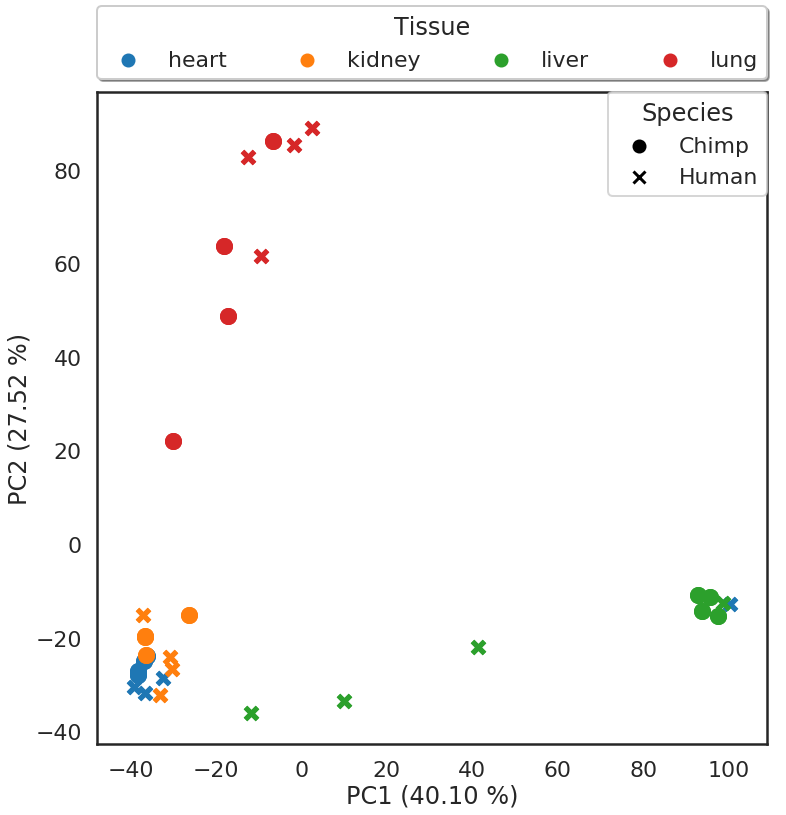

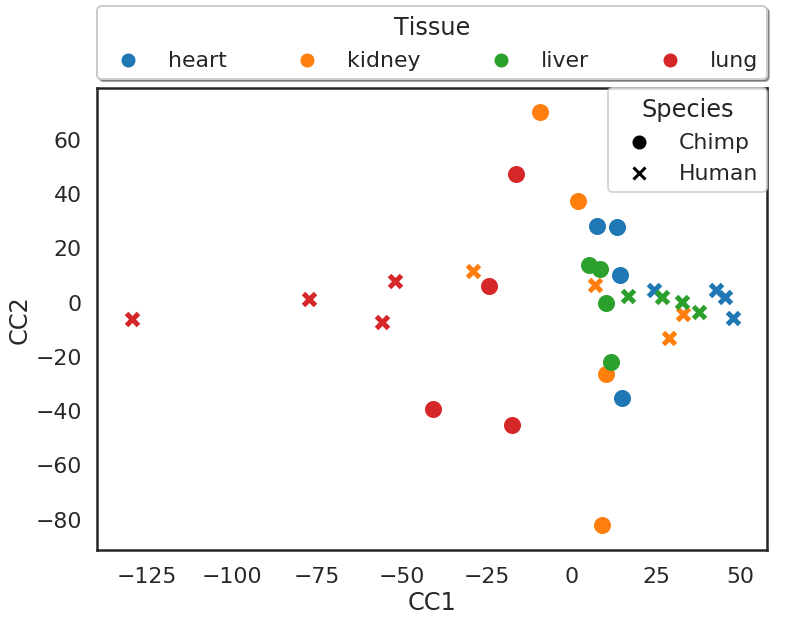

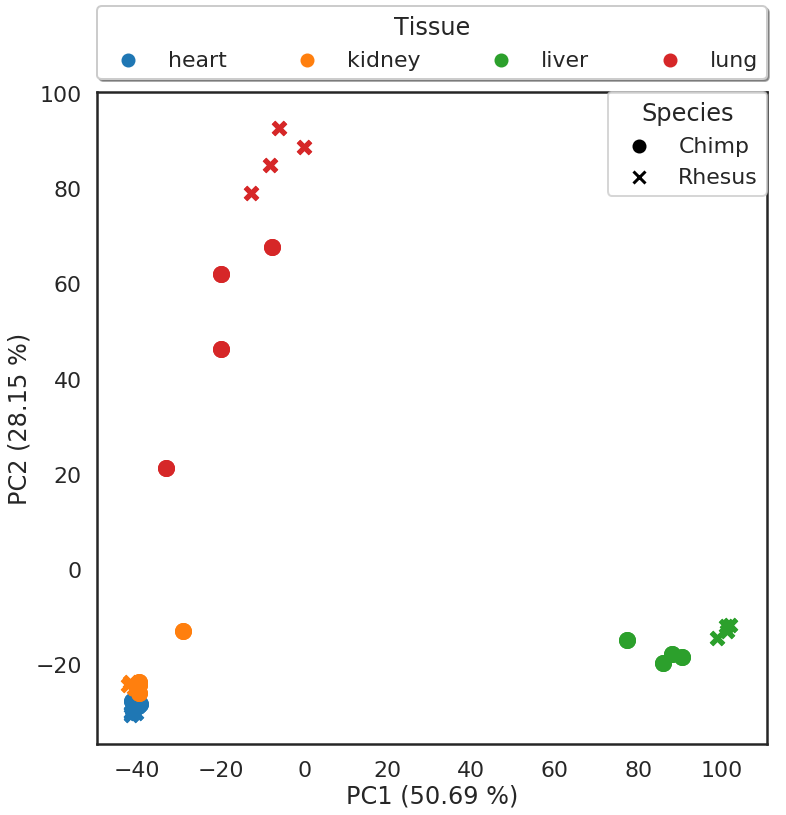

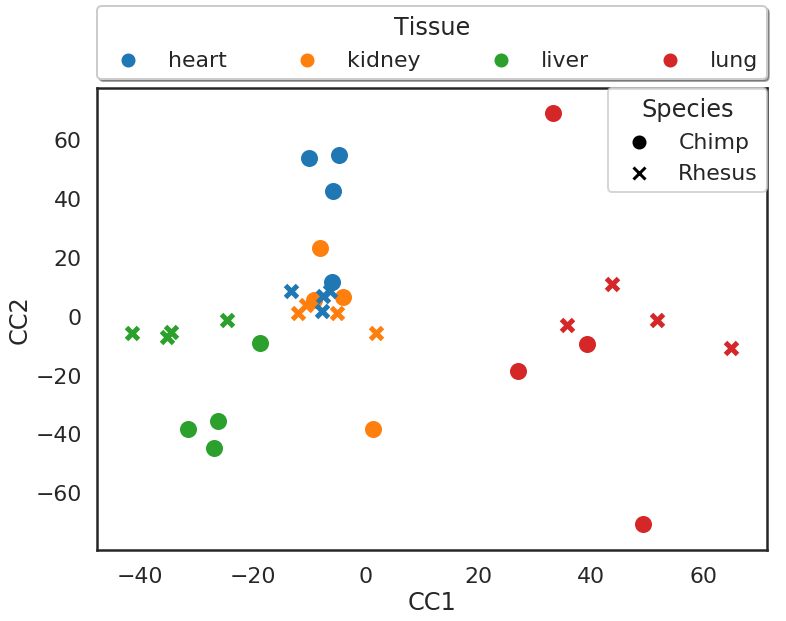

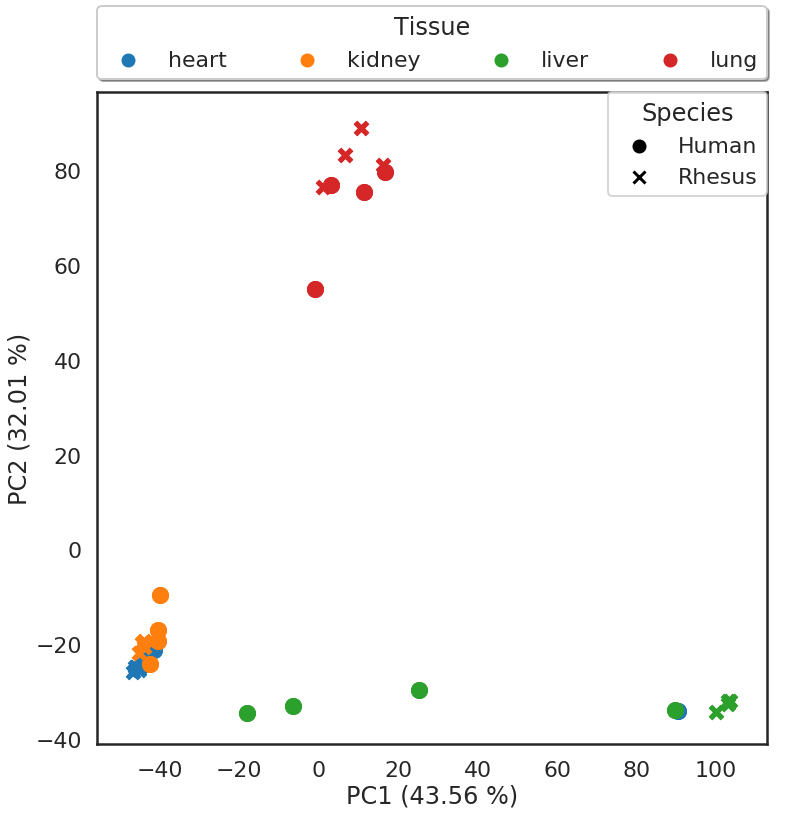

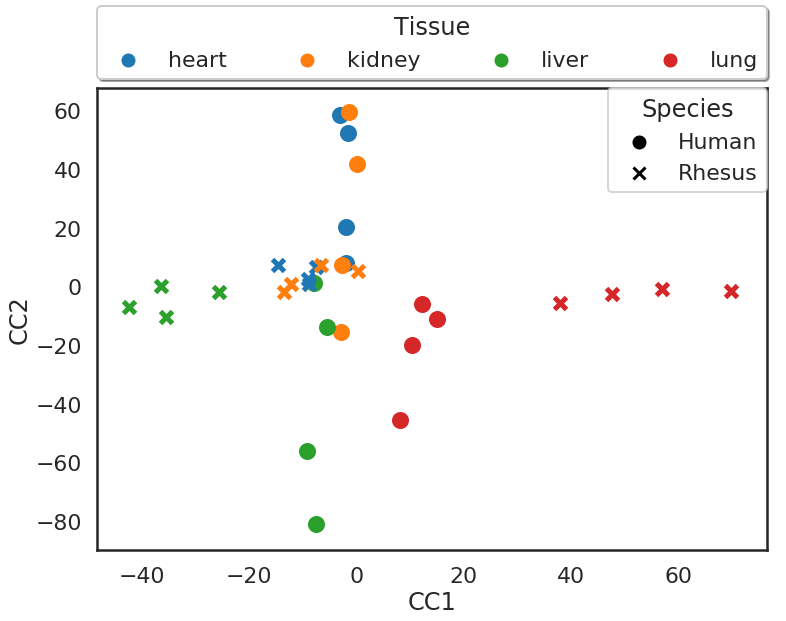

In [31]:
for species_pair, counts in pairwise_kallisto_counts_normalized.items():
    X = counts.values
    target_names = counts.index
    X_r, fig = do_PCA(X, target_names)
    species1, species2 = species_pair.split('_')
    fig.savefig('../SRP016501_plots/pca_normalized_{}_{}.pdf'.format(species, species2), 
                bbox_inches='tight')    
    X = pairwise_kallisto_counts_normalized_individual[species_pair][species1]
    Y = pairwise_kallisto_counts_normalized_individual[species_pair][species2] 
    fig = do_CCA(X, Y, target_names)
    fig.savefig('../SRP016501_plots/cca_normalized_{}_{}.pdf'.format(species, species2),
                bbox_inches='tight')    
    X = X_r[:X.shape[0],]
    Y = X_r[X.shape[0]:,]
    fig = do_CCA(X, Y, target_names)
    fig.savefig('../SRP016501_plots/cca_on_pca_{}_{}.pdf'.format(species, species2),
                bbox_inches='tight')    
    plt.close()


In [32]:
species = ["bos_taurus"
           "rattus_norvegicus",
           "pongo_abelii",
           "monodelphis_domestica",
           "macaca_mulatta",
           "pan_troglodytes",
           "mus_musculus",
           "homo_sapiens",
           "gallus_gallus",
           "ornithorhynchus_anatinus",
           "gorilla_gorilla",
           "pan_paniscus"]
species_short_form = []
for sp in species:                      
    short_form = sp[0]+sp.split('_')[-1]
    species_short_form.append(short_form)
    

## Load All orthologous genes at once

In [36]:
species_wise_tissues = defaultdict(list)

for f in glob.glob('../cross-species-data/SRP136499-*_kallisto_gene_tables.tsv'):
    sample_name = f.split('/')[-1].replace('_kallisto_gene_tables.tsv', '')
    srp, species = sample_name.split('-')
    
    #species = species[0] + species.split('_')[-1]
    df = pd.read_table(f)
    tissues = sorted(set([x.split('.')[0] for x in df.columns]))
    for index, tissue in enumerate(tissues):
        if tissue in TISSUES_SHORT_FORM_MAP.keys():
            tissues[index] = TISSUES_SHORT_FORM_MAP[tissue]
            
    species_wise_tissues[species]+=list(tissues)
srp = 'SRP136499'
ortho_pairwise = {}
all_orthologs = pd.DataFrame()
for f in ['../ortholog_tsv/mmusculus_{}.tsv'.format(x) for x in map(lambda s: species_short(s), species_wise_tissues.keys())]:
    if 'mmusculus_mmusculus' in f:
        continue
    second_species = f.split('/')[-1].replace('.tsv', '').split('_')[-1]
    df = pd.read_table(f)[['ensembl_gene_id', '{}_homolog_ensembl_gene'.format(second_species), '{}_homolog_orthology_type'.format(second_species)]].set_index('ensembl_gene_id')
    df = df[df['{}_homolog_orthology_type'.format(second_species)]=='ortholog_one2one'].drop(columns=['{}_homolog_orthology_type'.format(second_species)])
    all_orthologs = all_orthologs.join(df, how='outer')

In [37]:
all_orthologs_filtered = all_orthologs.copy()
for species in species_wise_tissues.keys():
    species = species_short(species)
    count = kallisto_counts['{}_{}'.format(srp, species)]
    if species == 'mmusculus':
        all_orthologs_filtered = all_orthologs_filtered[all_orthologs_filtered.index.isin(count.index)]
    else:
        all_orthologs_filtered = all_orthologs_filtered[all_orthologs_filtered['{}_homolog_ensembl_gene'.format(species)].isin(count.index)]

        

In [40]:
species_wise_tissues

defaultdict(list,
            {'pan_troglodytes': ['heart', 'kidney', 'liver', 'lung'],
             'homo_sapiens': ['heart', 'kidney', 'liver', 'lung'],
             'macaca_mulatta': ['heart', 'kidney', 'liver', 'lung']})

In [66]:
all_species_combined_counts_df = pd.DataFrame()
specie_wise_counts = []
specie_wise_index_tracker = []
specie_wise_target_names = {}
for index, species in enumerate(['pan_troglodytes', 'homo_sapiens', 'macaca_mulatta']):
    species = species_short(species)
    count = kallisto_counts['{}_{}'.format(srp, species)]
    col_key = '{}_homolog_ensembl_gene'.format(species)
   
    count = count.loc[all_orthologs_filtered[col_key]]
    
    
    if index == 0:
    #    column_order = count.columns.tolist()
        all_species_combined_counts_df = count
    
    else:
    #    count = count.loc[all_orthologs_filtered[col_key], column_order]
    #    count.columns = ['{}_{}'.format(species, x) for x in count.columns]
        count.columns = ['{}_{}'.format(species, x.split('.')[0]) for x in count.columns]
        count.index = all_species_combined_counts_df.index.tolist()
        #assert (count.columns == column_order).all()
        all_species_combined_counts_df = all_species_combined_counts_df.join(count, how='outer')
    
    specie_wise_counts.append(count)
    specie_wise_target_names[species] =     count.columns.tolist()
    specie_wise_index_tracker.append(count.shape[1])

In [67]:
count.columns

Index(['mmulatta_heart', 'mmulatta_kidney', 'mmulatta_liver', 'mmulatta_lung',
       'mmulatta_heart', 'mmulatta_kidney', 'mmulatta_liver', 'mmulatta_lung',
       'mmulatta_heart', 'mmulatta_kidney', 'mmulatta_liver', 'mmulatta_lung',
       'mmulatta_heart', 'mmulatta_kidney', 'mmulatta_liver', 'mmulatta_lung'],
      dtype='object')

In [68]:
all_species_combined_counts_df

,ptroglodytes_heart,ptroglodytes_kidney,ptroglodytes_liver,ptroglodytes_lung,ptroglodytes_heart.1,ptroglodytes_kidney.1,ptroglodytes_liver.1,ptroglodytes_lung.1,ptroglodytes_heart.2,ptroglodytes_kidney.2,...,mmulatta_liver,mmulatta_lung,mmulatta_heart,mmulatta_kidney,mmulatta_liver,mmulatta_lung,mmulatta_heart,mmulatta_kidney,mmulatta_liver,mmulatta_lung
ENSPTRG00000001055,1462.000000,2291.000000,1855.000000,3282.000000,676.000000,2096.000000,1895.000000,3923.000000,675.000000,2520.000000,...,1042.150000,1070.420000,217.028000,786.225000,1046.370000,1291.190000,209.034000,912.13500,1181.330000,1124.170000
ENSPTRG00000014064,7.000000,10.000000,14.999992,40.000000,5.000000,20.000040,5.000000,33.000020,8.000000,56.000000,...,361.333000,3608.960000,364.357000,281.109000,286.865000,5159.260000,261.689000,424.49600,485.969000,6278.000000
ENSPTRG00000021710,91.058300,141.498000,62.924500,70.785400,73.125700,148.962000,130.896000,80.240400,66.486500,128.588000,...,531.952000,94.468400,563.457000,136.410000,646.499000,92.334700,421.517000,102.61700,658.747000,96.893000
ENSPTRG00000009805,918.000300,860.999300,604.021000,1159.000600,883.000000,600.999860,803.378401,1549.251600,857.016000,1143.318900,...,391.191300,888.320700,1581.896740,366.932300,407.175701,1046.898900,959.216110,510.28530,683.283600,1034.542840
ENSPTRG00000040031,8982.570000,2193.401000,3729.268000,12937.346000,7168.900000,2305.665000,1031.281000,16863.670000,8930.810000,3665.305000,...,1253.212100,16883.378000,5431.389000,679.754080,348.982870,19205.355000,3241.733000,961.43194,706.984400,17197.437000
ENSPTRG00000048525,8284.000000,13799.022900,13167.983300,11795.984890,5014.996400,11885.977800,20904.015000,19957.010300,2770.003900,4945.997200,...,1224.004500,10464.038560,2003.004000,1650.996970,1151.997600,13424.968700,1797.999400,3108.99720,3337.002700,15167.990500
ENSPTRG00000000601,1663.999180,1447.000277,557.000140,1067.000600,1525.999300,1515.999300,651.999697,1259.000763,1975.000300,1556.999330,...,514.000000,1416.999700,1095.000300,2156.001970,578.000170,1895.000100,885.000000,2741.00400,584.001012,1698.000100
ENSPTRG00000009489,587.000000,2446.000000,121.000000,7425.000000,897.000000,2863.000000,249.000000,7256.000000,990.000000,2259.000000,...,1.000000,143.000000,6.000000,28.000000,2.000000,165.000000,4.000000,44.00000,5.000000,144.000000
ENSPTRG00000009491,22.517000,8.095210,9.170070,3422.170000,16.215000,9.090830,8.069020,5390.450000,21.460100,16.076700,...,13.000000,7227.000000,17.000000,4.000000,5.000000,7304.000000,10.000000,6.00000,6.000000,5821.000000
ENSPTRG00000009377,287.000000,182.000000,404.000000,129.000000,269.000000,500.000000,592.000000,46.000000,374.000000,151.000000,...,2053.000000,275.000000,256.000000,69.000000,1612.000000,287.000000,177.000000,121.00000,2264.000000,373.000000


In [69]:
all_species_combined_counts_df_T = all_species_combined_counts_df.T

In [70]:
all_species_combined_counts_df_normalized = normalize_df_rowwise(all_species_combined_counts_df_T)

eig_dim: 48


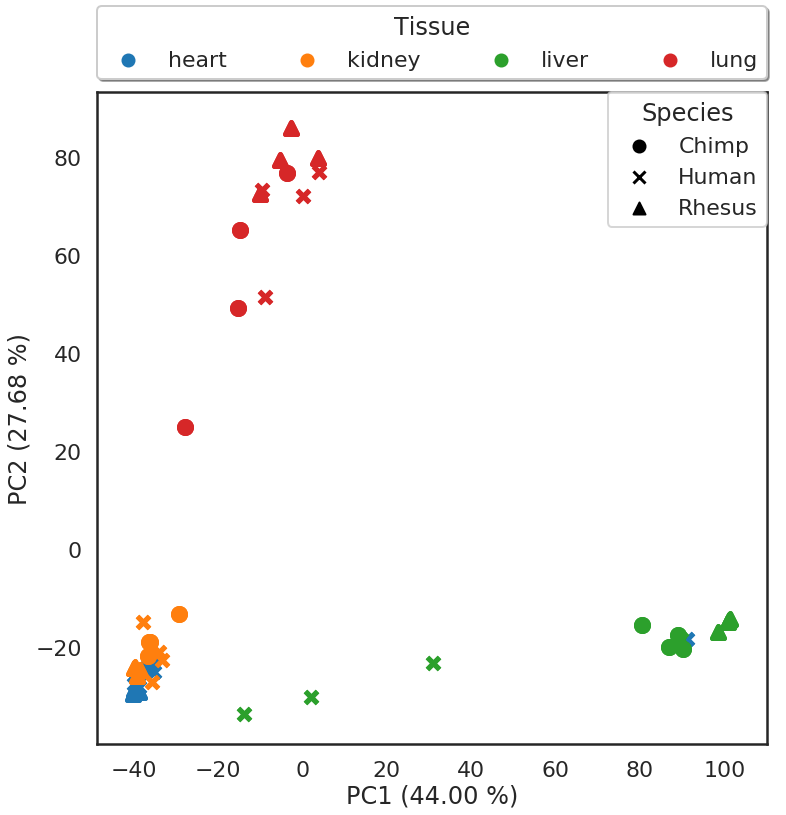

In [71]:
gcca = GCCA()
gcca.fit(specie_wise_counts[0],specie_wise_counts[1], specie_wise_counts[2])

gcca.transform(specie_wise_counts[0],specie_wise_counts[1], specie_wise_counts[2])


X = all_species_combined_counts_df_normalized.values
target_names = all_species_combined_counts_df_normalized.index
X_r, fig = do_PCA(X, target_names)
fig.savefig('../SRP136499_plots/pca_normalized_all.pdf', 
            bbox_inches='tight')    




eig_dim: 48


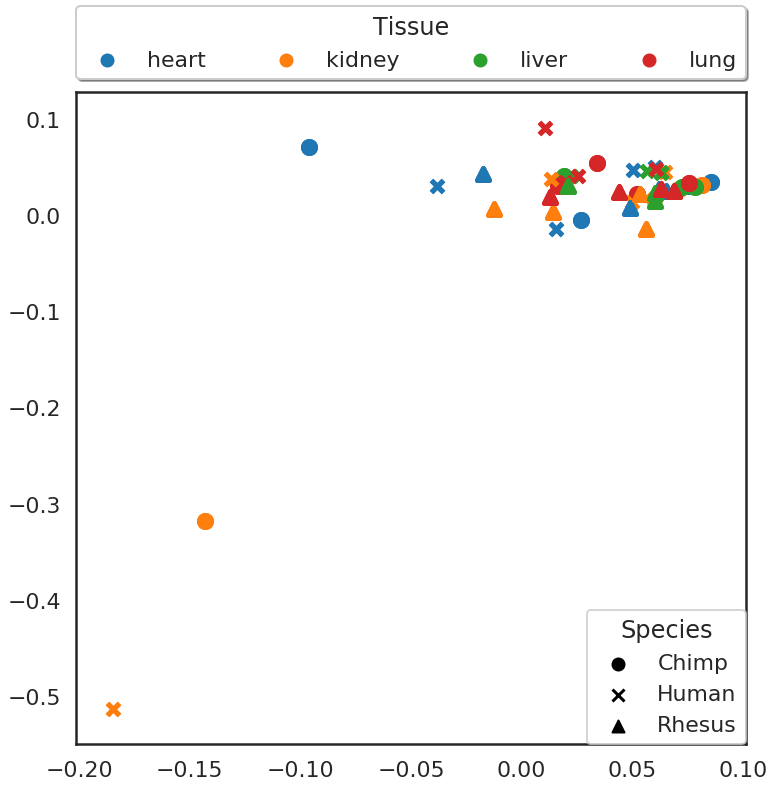

In [74]:
fig , ax  = plt.subplots(figsize=(12, 12))
gcca = GCCA()
gcca.fit(specie_wise_counts[0],specie_wise_counts[1], specie_wise_counts[2])

gcca.transform(specie_wise_counts[0],specie_wise_counts[1], specie_wise_counts[2])

X_r = gcca.z_list
target_names = all_species_combined_counts_df_normalized.index

indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)   

        
scatter_points = []
annotations = []
for index, species in enumerate(['pan_troglodytes', 'homo_sapiens', 'macaca_mulatta']):
    target_names = specie_wise_target_names[species_short(species)]
    indexes, _, _, _ , _ = _get_PCA_colors_markers(target_names)
    z_list = X_r[index]
    for tissue, values in indexes.items():
        for value in values:
            ax.scatter(z_list[value, 0], 
                       z_list[value, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_dict[species_short(species)],
                       lw=5) 

    
target_names = all_species_combined_counts_df_normalized.index
indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)   
for tissue, color in colors_dict.items():
    p = ax.scatter([], [], color=color, label=tissue)
    if tissue in TISSUES_SHORT_FORM_MAP.keys():
        tissue = TISSUES_SHORT_FORM_MAP[tissue]
    annotations.append(tissue)
    scatter_points.append(p)


leg = Legend(ax, scatter_points, annotations, title='Tissue',
             bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
             fancybox=True, shadow=True,borderaxespad=0,
             ncol=5, mode="expand")
ax.add_artist(leg)

scatter_points = []
annotations = []
for species, marker in markers_dict.items():
    p = ax.scatter([], [], marker=marker, color='black', label=species)
    annotations.append(SPECIES_COMMON_NAME_MAP_SHORT[species])
    scatter_points.append(p)

#leg = Legend(ax, scatter_points, annotations, title='Species',
#             bbox_to_anchor=(1.04, 0), loc="lower left",)# frameon=False)
leg = Legend(ax, scatter_points, annotations, title='Species',
             bbox_to_anchor=(1, 0), loc='lower right',borderaxespad=0,
             #bbox_to_anchor=(0.5, -0.05), loc=0, ncol=5,
             )# frameon=False)
ax.add_artist(leg)
fig.savefig('../SRP136499_plots/cca_normalized_all.pdf', bbox_inches='tight')

In [75]:
specie_wise_index_tracker

[16, 16, 16]

eig_dim: 45


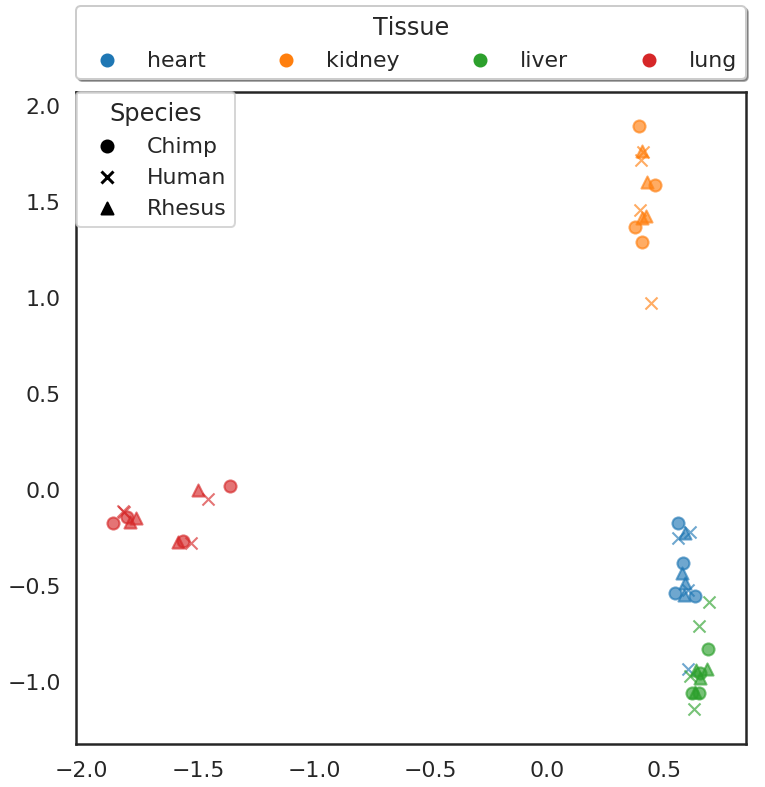

In [82]:
fig , ax  = plt.subplots(figsize=(12, 12))
gcca = GCCA()
PCA_transformed = PCA(n_components=min(all_species_combined_counts_df_normalized.shape)).fit(all_species_combined_counts_df_normalized).transform(all_species_combined_counts_df_normalized)
a,b,c = PCA_transformed[:specie_wise_index_tracker[0],:], PCA_transformed[specie_wise_index_tracker[0]:sum(specie_wise_index_tracker[:2]), :], PCA_transformed[sum(specie_wise_index_tracker[:2]):sum(specie_wise_index_tracker[:3]), :]
gcca.fit(a,b,c)

gcca.transform(a,b,c)
X_r = gcca.z_list
target_names = all_species_combined_counts_df_normalized.index

indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)   

        
scatter_points = []
annotations = []
for index, species in enumerate(['pan_troglodytes', 'homo_sapiens', 'macaca_mulatta']):
    target_names = specie_wise_target_names[species_short(species)]
    indexes, _, _, _ , _ = _get_PCA_colors_markers(target_names)
    z_list = X_r[index]
    for tissue, values in indexes.items():
        for value in values:
            ax.scatter(z_list[value, 0], 
                       z_list[value, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_dict[species_short(species)],
                       lw=2, alpha=0.4) 

    
target_names = all_species_combined_counts_df_normalized.index
indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)   
for tissue, color in colors_dict.items():
    p = ax.scatter([], [], color=color, label=tissue)
    if tissue in TISSUES_SHORT_FORM_MAP.keys():
        tissue = TISSUES_SHORT_FORM_MAP[tissue]
    annotations.append(tissue)
    scatter_points.append(p)


leg = Legend(ax, scatter_points, annotations, title='Tissue',
             bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
             fancybox=True, shadow=True,borderaxespad=0,
             ncol=5, mode="expand")
ax.add_artist(leg)

scatter_points = []
annotations = []
for species, marker in markers_dict.items():
    p = ax.scatter([], [], marker=marker, color='black', label=species)
    annotations.append(SPECIES_COMMON_NAME_MAP_SHORT[species])
    scatter_points.append(p)

#leg = Legend(ax, scatter_points, annotations, title='Species',
#             bbox_to_anchor=(1.04, 0), loc="lower left",)# frameon=False)
leg = Legend(ax, scatter_points, annotations, title='Species',
             bbox_to_anchor=(0, 1), loc='upper left',borderaxespad=0, shadow=False,
             #bbox_to_anchor=(0.5, -0.05), loc=0, ncol=5,
             )# frameon=False)
ax.add_artist(leg)
fig.savefig('../SRP136499_plots/cca_on_pca_all.pdf',bbox_inches='tight')